<a href="https://colab.research.google.com/github/Pulsar-kkaturi/Deepnoid-Education/blob/master/notebooks/CNN_VGG_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NEURAL NETWORK BUILD

# 1. LIbrary Import

In [ ]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd
import csv
import shutil
import json
from sklearn import metrics as skmet
from skimage import morphology
from skimage import measure
from skimage import exposure

### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K

# 2. Module Fuction

* keras application VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

* Block

In [ ]:
class ConvBlock:
    def conv_block_2d(self, lr_conv, lr_num, par_list):
        # parameter
        conv_size = par_list[0]
        conv_str = par_list[1]
        conv_act = par_list[2]
        pool_str = par_list[3]
        reg_weight = None
        # code
        for i in range(lr_num):
            lr_conv = layers.Conv2D(conv_size, conv_str, activation=conv_act, padding='same', 
                                    kernel_initializer='he_normal')(lr_conv)
        lr_batn = layers.BatchNormalization(axis=-1)(lr_conv)
        lr_pool = layers.MaxPooling2D(pool_size=pool_str)(lr_batn)
        return lr_pool
    def conv_block_3d(self, lr_input, lr_num, par_list):
        # parameter
        conv_size = par_list[0]
        conv_str = par_list[1]
        conv_act = par_list[2]
        pool_str = par_list[3]
        drop_rate = par_list[4]
        # code
        for i in range(lr_num):
            lr_conv = layers.Conv3D(conv_size, conv_str, activation=conv_act,
                                    padding='same', kernel_initializer='he_normal')(lr_input)
        lr_batn = layers.BatchNormalization(axis=-1)(lr_conv)
        lr_pool = layers.MaxPooling3D(pool_size=(pool_str, pool_str, pool_str))(lr_batn)
        return lr_pool
    def output_block(self, lr_dense, block_num, flat_count, reg_weight, act_func, drop_rate):
        lr_dense = layers.Flatten()(lr_dense)
        lr_dense = layers.Dropout(drop_rate)(lr_dense)
        for i in range(block_num):
            lr_dense = layers.Dense(flat_count[i], kernel_regularizer=reg_weight,
                                    activation=act_func)(lr_dense)
#             lr_dense = layers.BatchNormalization(axis=-1)(lr_dense)
#             lr_dense = layers.Activation(act_func)(lr_dense)
            lr_dense = layers.Dropout(drop_rate)(lr_dense)
        return lr_dense
    
cn = ConvBlock()

In [ ]:
def VGG16_2D(par_dic):
    # parameters
    input_size = par_dic['input_size']
    drop_out = par_dic['drop_out']
    reg_weight = par_dic['reg_weight']
    flat_count = par_dic['flat_count']
    class_count = par_dic['class_count']
    conv_act = par_dic['conv_act']
    flat_act = par_dic['flat_act']
    output_act = par_dic['output_act']
    conv_str = par_dic['conv_str']
    pool_str = par_dic['pool_str']
    dens_num = par_dic['dens_num']

    # code block
    inputs = Input(shape=(input_size, input_size, 1))
    block1 = cn.conv_block_2d(inputs, 2, [64, conv_str, conv_act, pool_str, reg_weight])
    block2 = cn.conv_block_2d(block1, 2, [128, conv_str, conv_act, pool_str, reg_weight])
    block3 = cn.conv_block_2d(block2, 3, [256, conv_str, conv_act, pool_str, reg_weight])
    block4 = cn.conv_block_2d(block3, 3, [512, conv_str, conv_act, pool_str, reg_weight])
    block5 = cn.conv_block_2d(block4, 3, [512, conv_str, conv_act, pool_str, reg_weight])
    dens = cn.output_block(block5, dens_num, flat_count, reg_weight, flat_act, drop_out)
    outputs = layers.Dense(class_count, activation=output_act)(dens)
    model = Model(inputs, outputs)
    return model

In [ ]:
def VGG16_3D(input_size, block_num, drop_out, flat_count, class_count, conv_act, flat_act, output_act,
           conv_str, pool_str):

    inputs = Input(shape=(input_size, input_size, input_size, 1))
    block1 = cn.conv_block_3d(inputs, 2, [64, conv_str, conv_act, pool_str, drop_out])
    block2 = cn.conv_block_3d(block1, 2, [128, conv_str, conv_act, pool_str, drop_out])
    block3 = cn.conv_block_3d(block2, 3, [256, conv_str, conv_act, pool_str, drop_out])
    block4 = cn.conv_block_3d(block3, 3, [512, conv_str, conv_act, pool_str, drop_out])
    block5 = cn.conv_block_3d(block4, 3, [512, conv_str, conv_act, pool_str, drop_out])
    flat = layers.Flatten()(block5)
    drop1 = layers.Dropout(drop_out)(flat)
    dens = layers.Dense(flat_count, activation=flat_act)(drop1)
    drop2 = layers.Dropout(drop_out)(dens)
    outputs = layers.Dense(class_count, activation=output_act)(drop2)
    model = Model(inputs, outputs)
    return model

# 3. Dataset

In [ ]:
(x_train, y_train), (x_test, y_test)=keras.datasets.mnist.load_data(path='minist.npz')

In [ ]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


# 3.1 2D dataset

In [ ]:
x_train_list = []
x_test_list = []
for i, i_ in enumerate(x_train[:50000]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_train[i]
    x_train_list.append(arr)
for i, i_ in enumerate(x_test[:5000]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_test[i]
    x_test_list.append(arr)

x_train1 = np.expand_dims(np.array(x_train_list), axis=-1)
x_test1 = np.expand_dims(np.array(x_test_list), axis=-1)
print(x_train1.shape, x_test1.shape)

(50000, 32, 32, 1) (5000, 32, 32, 1)


In [ ]:
y_train_list = []
y_test_list = []
for i, i_ in enumerate(y_train[:50000]):
    zero = [0]*10
    zero[i_] = 1
    y_train_list.append(zero)

for i, i_ in enumerate(y_test[:5000]):
    zero = [0]*10
    zero[i_] = 1
    y_test_list.append(zero)    
    
y_train1 = np.array(y_train_list)
y_test1 = np.array(y_test_list)
print(y_train1.shape, y_test1.shape)

(50000, 10) (5000, 10)


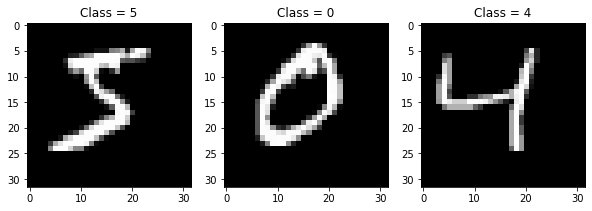

In [ ]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(x_train1[i][...,0], cmap='gray')
    plt.title('Class = {}'.format(y_train[i]))

## 3.2 3D dataset

In [ ]:
x_train_list = []
y_train_list = []
x_test_list = []
y_test_list = []
for i in range(1200):
    zero = np.zeros(shape=(32,32,32))
    ones = np.ones(shape=(16,16,16))
    ran = int(np.random.randint(10, size=1)-5)
    if 0 <= i < 400:
        zero[:,:,:] = (ran*10) + 150
        x_train_list.append(zero)
        y_train_list.append([1,0,0])
    elif 400 <= i < 800:
        zero[8+ran:24+ran,8+ran:24+ran,8+ran:24+ran] = (ran*10) + 200
        x_train_list.append(zero)
        y_train_list.append([0,1,0])
    elif 800 <= i < 1200:
        for j in range(32):
            for k in range(32):
                for l in range(32):
                    if ((j-16+ran)**2) + ((k-16+ran)**2) + ((l-16+ran)**2) < 100:
                        zero[j,k,l] = (ran*10) + 200
        x_train_list.append(zero)
        y_train_list.append([0,0,1])

for i in range(600):
    zero = np.zeros(shape=(32,32,32))
    ones = np.ones(shape=(16,16,16))
    ran = int(np.random.randint(10, size=1)-5)
    if 0 <= i < 200:
        zero[:,:,:] = (ran*10) + 150
        x_test_list.append(zero)
        y_test_list.append([1,0,0])
    elif 200 <= i < 400:
        zero[8+ran:24+ran,8+ran:24+ran,8+ran:24+ran] = (ran*10) + 200
        x_test_list.append(zero)
        y_test_list.append([0,1,0])
    elif 400 <= i < 600:
        for j in range(32):
            for k in range(32):
                for l in range(32):
                    if ((j-16+ran)**2) + ((k-16+ran)**2) + ((l-16+ran)**2) < 100:
                        zero[j,k,l] = (ran*10) + 200
        x_test_list.append(zero)
        y_test_list.append([0,0,1])

x3_train1 = np.expand_dims(np.array(x_train_list), axis=-1)
x3_test1 = np.expand_dims(np.array(x_test_list), axis=-1)
y3_train1 = np.array(y_train_list)
y3_test1 = np.array(y_test_list)
print(x3_train1.shape, x3_test1.shape)
print(y3_train1.shape, y3_test1.shape)

(1200, 32, 32, 32, 1) (600, 32, 32, 32, 1)
(1200, 3) (600, 3)


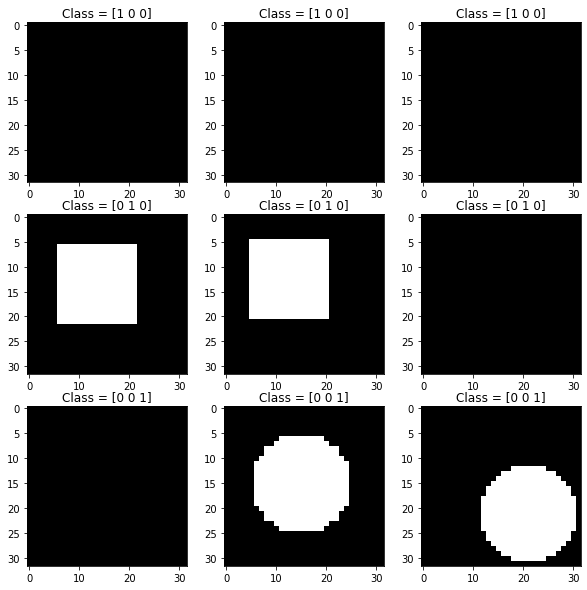

In [ ]:
plt.figure(figsize=(10,10))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3, (3*i)+j+1)
        plt.imshow(x3_train1[(i*400)+(j*100)][(8*j)+8,...,0], cmap='gray')
        plt.title('Class = {}'.format(str(y3_train1[(i*400)+(j*100)])))


# 3. Model Build

## 3.1 2D

In [ ]:
train_param_set = {'cls_vgg': {'model_name': 'VGG19',
                               'array_dim': '2d',
                               'split_rate': 0.2,
                               'k_fold': 5,
                               'aug_rate': {'benign': 4, 'malignant': 4},
                               'batch_size': 50,
                               'epoch': 100,
                               'gpu_vision': '0,1,2,3',
                               'loss': losses.CategoricalCrossentropy(),
                               'learning_rate': '1e-4',
                               'optimizer': optimizers.Adam(lr=1e-4),
                               'metric': ['accuracy'],
                               'threshold': 0.5,
                               'ensemble_mode': 'soft',
                               'positive_idx': 0,
                               'smode_in': None,
                               'smode_out': 'pred',
                               'sample_mode': False,
                               'step_list': {'hold_out': [1, 2, 3, 4, 5, 6],
                                             'k_fold': [1, 2.1, 2.2, 2.3, 2.4, 3, 4, 5]}}}

network_param_set = {'vgg': {'input_size': 32,
                             'block_num': 1,
                             'layer_num': 1,
                             'drop_out': 0.5,
                             'reg_weight': regularizers.l2(1e-3),
                             'dens_num': 2,
                             'flat_count': [1000, 500],
                             'class_count': 10,
                             'conv_act': 'relu',
                             'flat_act': 'relu',
                             'output_act': 'softmax',
                             'conv_str': 3,
                             'pool_str': 2}}

In [ ]:
model = VGG16_2D(network_param_set['vgg'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)       1475

In [ ]:
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(lr=1e-5), metrics=['acc'])


In [ ]:
callback_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
                         keras.callbacks.ModelCheckpoint(filepath=os.path.join('model.h5'),
                                                         monitor='val_loss', save_best_only=True),
                         keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)]

history = model.fit(x_train1, y_train1, epochs=100, batch_size=32, 
                    validation_data=(x_test1, y_test1),
                    callbacks=callback_list, shuffle=True)

Train on 50000 samples, validate on 5000 samples
Epoch 1/100
50000/50000 [==============================] - 51s 1ms/sample - loss: 3.5326 - acc: 0.3820 - val_loss: 1.8008 - val_acc: 0.8850
Epoch 2/100
50000/50000 [==============================] - 47s 938us/sample - loss: 1.8617 - acc: 0.8287 - val_loss: 1.4910 - val_acc: 0.9482
Epoch 3/100
50000/50000 [==============================] - 47s 939us/sample - loss: 1.5481 - acc: 0.9306 - val_loss: 1.4215 - val_acc: 0.9634
Epoch 4/100
50000/50000 [==============================] - 47s 942us/sample - loss: 1.4347 - acc: 0.9592 - val_loss: 1.3931 - val_acc: 0.9674
Epoch 5/100
50000/50000 [==============================] - 47s 941us/sample - loss: 1.3635 - acc: 0.9717 - val_loss: 1.3330 - val_acc: 0.9738
Epoch 6/100
50000/50000 [==============================] - 47s 942us/sample - loss: 1.2999 - acc: 0.9795 - val_loss: 1.2826 - val_acc: 0.9758
Epoch 7/100
50000/50000 [==============================] - 47s 948us/sample - loss: 1.2351 - acc: 0.9

50000/50000 [==============================] - 47s 936us/sample - loss: 0.0064 - acc: 0.9995 - val_loss: 0.0615 - val_acc: 0.9876
Epoch 59/100
50000/50000 [==============================] - 47s 936us/sample - loss: 0.0056 - acc: 0.9998 - val_loss: 0.0704 - val_acc: 0.9860
Epoch 60/100
50000/50000 [==============================] - 47s 932us/sample - loss: 0.0056 - acc: 0.9998 - val_loss: 0.0687 - val_acc: 0.9858
Epoch 61/100
50000/50000 [==============================] - 47s 938us/sample - loss: 0.0053 - acc: 0.9998 - val_loss: 0.0700 - val_acc: 0.9856
Epoch 62/100
50000/50000 [==============================] - 47s 941us/sample - loss: 0.0051 - acc: 0.9998 - val_loss: 0.0994 - val_acc: 0.9802
Epoch 63/100
50000/50000 [==============================] - 47s 938us/sample - loss: 0.0063 - acc: 0.9995 - val_loss: 0.0615 - val_acc: 0.9874
Epoch 64/100
50000/50000 [==============================] - 47s 939us/sample - loss: 0.0061 - acc: 0.9995 - val_loss: 0.0620 - val_acc: 0.9868
Epoch 65/100

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
# Accuracy graph
plt.figure(figsize=(10, 10))
plt.plot(epochs, acc, 'b', label='Training acc = {}%'.format(np.around(np.max(acc) * 100, decimals=1)))
plt.plot(epochs, val_acc, 'r', label='Validation acc = {}%'.format(np.around(np.max(val_acc) * 100, decimals=1)))
plt.title('{} Accuracy (Total Epoch = {})'.format('VGG16', len(acc)), fontsize=15, y=1.02)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.show()
# Loss graph
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, 'b', label='Training loss = {}'.format(np.around(np.min(loss), decimals=3)))
plt.plot(epochs, val_loss, 'r', label='Validation loss= {}'.format(np.around(np.min(val_loss), decimals=3)))
plt.title('{} Loss (Total Epoch = {})'.format('VGG16', len(loss)), fontsize=15, y=1.02)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.show()

## 3.2 3D 

In [ ]:
model = VGG16_3D(32, 1, 0.5, 256, 3, 'relu', 'relu', 'softmax', 3, 2)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 32, 1)]   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 32, 32, 32, 64)    1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32, 64)    256       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 16, 16, 16, 64)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 16, 16, 16, 128)   221312    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16, 128)   512       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 8, 8, 128)      0     

In [ ]:
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(lr=1e-5), metrics=['acc'])
callback_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=12),
                         keras.callbacks.ModelCheckpoint(filepath=os.path.join('model.h5'),
                                                         monitor='val_loss', save_best_only=True),
                         keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)]

history = model.fit(x3_train1, y3_train1, epochs=100, batch_size=32, 
                    validation_data=(x3_test1, y3_test1),
                    callbacks=callback_list, shuffle=True)

Train on 1200 samples, validate on 600 samples
Epoch 1/100
1200/1200 [==============================] - 12s 10ms/sample - loss: 0.7309 - acc: 0.8250 - val_loss: 7.4159 - val_acc: 0.3333
Epoch 2/100
1200/1200 [==============================] - 7s 6ms/sample - loss: 0.0624 - acc: 0.9767 - val_loss: 2.1473 - val_acc: 0.3917
Epoch 3/100
1200/1200 [==============================] - 7s 6ms/sample - loss: 0.0446 - acc: 0.9825 - val_loss: 0.1712 - val_acc: 0.9633
Epoch 4/100
1200/1200 [==============================] - 7s 6ms/sample - loss: 0.0224 - acc: 0.9950 - val_loss: 0.0159 - val_acc: 1.0000
Epoch 5/100
1200/1200 [==============================] - 7s 6ms/sample - loss: 0.0159 - acc: 0.9975 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 6/100
1024/1200 [========================>.....] - ETA: 0s - loss: 0.0092 - acc: 0.9990

KeyboardInterrupt: 

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
# Accuracy graph
plt.figure(figsize=(10, 10))
plt.plot(epochs, acc, 'b', label='Training acc = {}%'.format(np.around(np.max(acc) * 100, decimals=1)))
plt.plot(epochs, val_acc, 'r', label='Validation acc = {}%'.format(np.around(np.max(val_acc) * 100, decimals=1)))
plt.title('{} Accuracy (Total Epoch = {})'.format('VGG16', len(acc)), fontsize=15, y=1.02)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.show()
# Loss graph
plt.figure(figsize=(10, 10))
plt.plot(epochs, loss, 'b', label='Training loss = {}'.format(np.around(np.min(loss), decimals=3)))
plt.plot(epochs, val_loss, 'r', label='Validation loss= {}'.format(np.around(np.min(val_loss), decimals=3)))
plt.title('{} Loss (Total Epoch = {})'.format('VGG16', len(loss)), fontsize=15, y=1.02)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.show()

# 4. Additional Model

# 4.1 VGG19

* keras application

In [ ]:
from tensorflow.keras.applications import VGG19
model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model.summary()

In [ ]:
def VGG19_2D(input_size, drop_out, flat_count, class_count, conv_act, flat_act, output_act, conv_str, pool_str):

    inputs = Input(shape=(input_size, input_size, 1))
    block1 = cn.conv_block_2d(inputs, 2, [64, conv_str, conv_act, pool_str, drop_out])
    block2 = cn.conv_block_2d(block1, 2, [128, conv_str, conv_act, pool_str, drop_out])
    block3 = cn.conv_block_2d(block2, 4, [256, conv_str, conv_act, pool_str, drop_out])
    block4 = cn.conv_block_2d(block3, 4, [512, conv_str, conv_act, pool_str, drop_out])
    block5 = cn.conv_block_2d(block4, 4, [512, conv_str, conv_act, pool_str, drop_out])
    flat = layers.Flatten()(block5)
    drop1 = layers.Dropout(drop_out)(flat)
    dens = layers.Dense(flat_count, activation=flat_act)(drop1)
    drop2 = layers.Dropout(drop_out)(dens)
    outputs = layers.Dense(class_count, activation=output_act)(drop2)
    model = Model(inputs, outputs)
    return model

model = VGG19_2D(32, 0.5, 256, 2, 'relu', 'relu', 'sigmoid', 3, 2)
model.summary()

In [ ]:
def VGGfree_2D(input_size, block_num, layer_num, drop_out, flat_count, class_count, conv_act, flat_act, output_act, conv_str, pool_str):

    inputs = Input(shape=(input_size, input_size, 1))
    block = layers.Conv2D(32, conv_str, activation=conv_act, padding='same', kernel_initializer='he_normal')(inputs)
    for i in range(block_num):
        block = cn.conv_block_2d(block, layer_num, [32*(2**i), conv_str, conv_act, pool_str, drop_out])
    flat = layers.Flatten()(block)
    drop1 = layers.Dropout(drop_out)(flat)
    dens = layers.Dense(flat_count, activation=flat_act)(drop1)
    drop2 = layers.Dropout(drop_out)(dens)
    outputs = layers.Dense(class_count, activation=output_act)(drop2)
    model = Model(inputs, outputs)
    return model

model = VGGfree_2D(32, 5, 2, 0.5, 256, 2, 'relu', 'relu', 'sigmoid', 3, 2)
model.summary()